# Análisis de las imágenes

## Carga del Dataset
Vamos a definir una clase, que tome como base la clase Dataset de Pytorch, para poder cargar todo nuestro conjunto de imágenes de uno o varios canales con su máscara correspondiente.

In [1]:
import os

print("Vamos a cambiar el directorio de trabajo")

# Indicamos la ruta del directorio de trabajo
route = os.getcwd()+"/TFG/test/PNe_segmentation"
os.chdir(route)

current_directory = os.getcwd()
print(" El directorio actual es:", current_directory)

# Listamos el contenido del directorio
files = os.listdir(current_directory)
print(" Contenido del directorio actual:")
for file in files:
    print("\t",file)
    
# Listamos el contenido del directorio de las máscaras
# masks_directory = route+"TFG\\test\\PNe_segmentation\\masks"
# data_directory = route+"TFG\\test\\PNe_segmentation\\data"
## Ejecución en el CESGA Finisterrae III
masks_directory = current_directory+"/masks"
data_directory = current_directory+"/data"


Vamos a cambiar el directorio de trabajo
 El directorio actual es: /mnt/netapp2/Home_FT2/home/ulc/co/ela/TFG/test/PNe_segmentation
 Contenido del directorio actual:
	 train_models
	 data
	 create_dataset.ipynb
	 data_files_1c.csv
	 images
	 image_analysis.ipynb
	 masks
	 segmentation_no_supervisada.ipynb
	 segmentation_no_supervisada_2c.ipynb
	 segmentation_no_supervisada_pytorch.ipynb
	 segmentation_supervisada.ipynb
	 dataset_info.csv
	 data_files_1c_train.csv
	 historico_notebooks
	 data_files_1c_test.csv
	 segmentation_no_supervisada_pytorch_clean.ipynb
	 segmentation_supervisada_pytorch copy.ipynb
	 segmentation_supervisada_pytorch.ipynb
	 cesga
	 segmentation_supervisada_pytorch copy 2.ipynb
	 segmentation_supervisada_pytorch copy 3.ipynb
	 data_files_1c_train_correct.csv


## Valor mínimo y máximo del dataset

In [2]:
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.normalize import MinMaxImageNorm
from torchvision import transforms
import torch
import pandas as pd

# Creamos un objeto de la clase PNeDataset
transform_x = transforms.Compose([
                    transforms.Lambda(lambda x: torch.from_numpy(x.copy()).unsqueeze_(0))
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: torch.Tensor.int(x.round()))
                    ])

df_train = pd.read_csv("data_files_1c_train_correct.csv")
dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))

Se utiliza el .csv corregido debido a que había una imagen con valores completamente atípicos y que no se veía nada visualmente hablando

In [3]:
min_values = []
max_values = []

for i in range(len(dataset_train)):
    min_values.append(dataset_train[i][0].min())
    max_values.append(dataset_train[i][0].max())

print("Min value:", min(min_values))
print("Max value:", max(max_values))

Min value: tensor(-88.9933)
Max value: tensor(125873.7500)


## Procesamiento de ventanas

In [6]:
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.normalize import MinMaxImageNorm, TypicalImageNorm
from pnebulae_torch.preprocess import ApplyIntensityTransformation, CutValues
from skimage import exposure
from torchvision import transforms
import torch
import pandas as pd

# Creamos un objeto de la clase PNeDataset
transform_x = transforms.Compose([
                    # MinMaxImageNorm(),
                    # TypicalImageNorm(),
                    CutValues(factor = 2),
                    ApplyIntensityTransformation(exposure.equalize_hist, nbins = 256, concat = True),
                    # transforms.Lambda(lambda x: torch.from_numpy(x.copy()).unsqueeze_(0))
                    transforms.ToTensor()
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: torch.Tensor.int(x.round()))
                    ])

df_train = pd.read_csv("data_files_1c_train_correct.csv")
dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))

In [48]:
import matplotlib.pyplot as plt
import random as rd

window_size = 9

nebulae_windows = []
background_windows = []

for i, (image, mask) in enumerate(dataset_train):
    neb_index = (mask == 1).nonzero()
    back_index = (mask == 0).nonzero()

    cnt = 0
    mask_neb_window = torch.zeros(window_size, window_size)
    while mask_neb_window.sum() != window_size**2:
        rd_neb_pixel = neb_index[rd.randint(0, len(neb_index)-1)]
        image_neb_window = image[:, rd_neb_pixel[1]-window_size//2:rd_neb_pixel[1]+window_size//2+1, rd_neb_pixel[2]-window_size//2:rd_neb_pixel[2]+window_size//2+1]
        mask_neb_window = mask[:, rd_neb_pixel[1]-window_size//2:rd_neb_pixel[1]+window_size//2+1, rd_neb_pixel[2]-window_size//2:rd_neb_pixel[2]+window_size//2+1]
        cnt += 1
        if cnt > 1000:
            print("Error in image", i)
            break
    
    if cnt > 1000:
        continue
    
    mask_back_window = torch.ones(window_size, window_size)
    while mask_back_window.sum() != 0:
        rd_back_pixel = back_index[rd.randint(0, len(back_index)-1)]
        image_back_window = image[:, rd_back_pixel[1]-window_size//2:rd_back_pixel[1]+window_size//2+1, rd_back_pixel[2]-window_size//2:rd_back_pixel[2]+window_size//2+1]
        mask_back_window = mask[:, rd_back_pixel[1]-window_size//2:rd_back_pixel[1]+window_size//2+1, rd_back_pixel[2]-window_size//2:rd_back_pixel[2]+window_size//2+1]
        if image_back_window.shape != (1, window_size, window_size):
            mask_back_window = torch.ones(window_size, window_size)
    
    nebulae_windows.append(image_neb_window)
    background_windows.append(image_back_window)
    
nebulae_windows = torch.stack(nebulae_windows)
background_windows = torch.stack(background_windows)

Error in image 103


In [49]:
nebulae_stats = [(mean.item(), std.item(), minimo.item(), maximo.item()) for mean, std, minimo, maximo in zip(nebulae_windows.mean(dim = [1,2,3]), nebulae_windows.std(dim = [1,2,3]), nebulae_windows.min(dim = 3)[0].min(dim = 2)[0], nebulae_windows.max(dim = 3)[0].max(dim = 2)[0])]
background_stats = [(mean.item(), std.item(), minimo.item(), maximo.item()) for mean, std, minimo, maximo in zip(background_windows.mean(dim = [1,2,3]), background_windows.std(dim = [1,2,3]), background_windows.min(dim = 3)[0].min(dim = 2)[0], background_windows.max(dim = 3)[0].max(dim = 2)[0])]

Nebulae stats: (43.459503173828125, 1.5849159955978394, 40.31168746948242, 46.7052001953125)
Background stats: (38.90422821044922, 1.6390085220336914, 35.07286834716797, 42.249755859375)
General image stats: tensor(37.9692) tensor(4.5177) tensor(10.4342) tensor(93.1746)


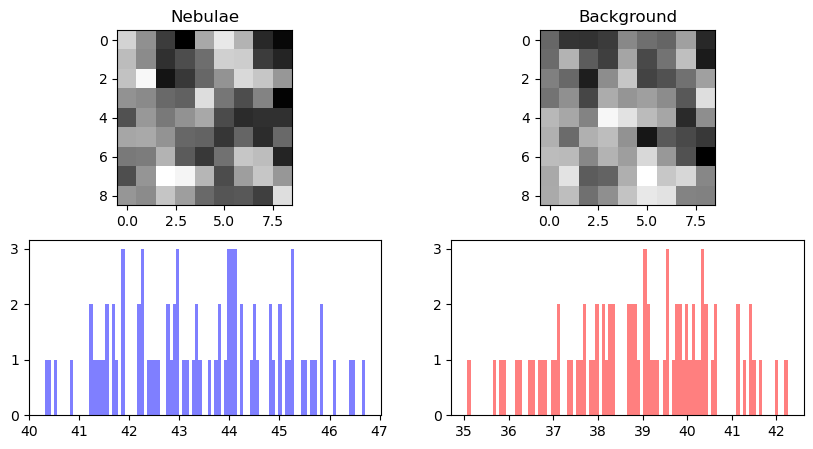

In [50]:
index = 4
print("Nebulae stats:", nebulae_stats[index])
print("Background stats:", background_stats[index])
print("General image stats:", dataset_train[index][0].mean(), dataset_train[index][0].std(), dataset_train[index][0].min(), dataset_train[index][0].max())
fig, axis = plt.subplots(2, 2, figsize = (10, 5))
axis[0,0].imshow(nebulae_windows[index][0], cmap = "gray")
axis[0,0].set_title("Nebulae")
axis[0,1].imshow(background_windows[index][0], cmap = "gray")
axis[0,1].set_title("Background")

axis[1,0].hist(nebulae_windows[index].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
axis[1,1].hist(background_windows[index].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Background")

plt.show()


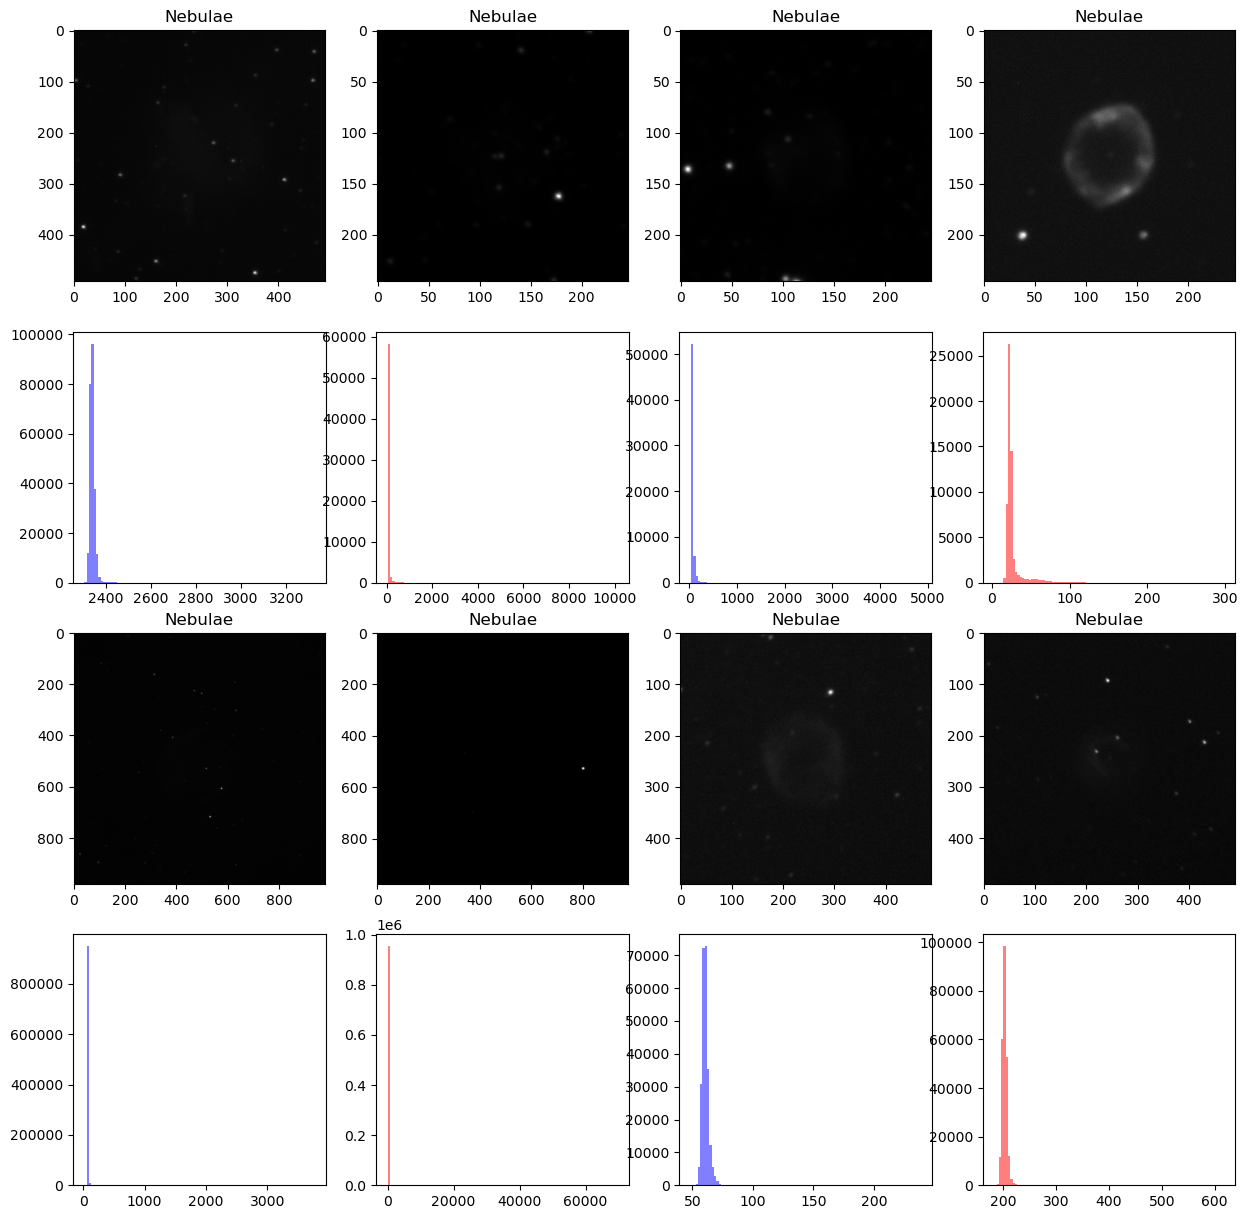

In [43]:
fig, axis = plt.subplots(4, 4, figsize = (15, 15))

init_index = 16

for i in range(2):
    axis[2*i,0].imshow(dataset_train[init_index+i][0][0], cmap = "gray")
    axis[2*i,0].set_title("Nebulae")
    
    axis[2*i,1].imshow(dataset_train[init_index+i+1][0][0], cmap = "gray")
    axis[2*i,1].set_title("Nebulae")
    
    axis[2*i,2].imshow(dataset_train[init_index+i+2][0][0], cmap = "gray")
    axis[2*i,2].set_title("Nebulae")
    
    axis[2*i,3].imshow(dataset_train[init_index+i+3][0][0], cmap = "gray")
    axis[2*i,3].set_title("Nebulae")
    
    _ = axis[2*i+1,0].hist(dataset_train[init_index+i][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
    _ = axis[2*i+1,1].hist(dataset_train[init_index+i+1][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Nebulae")
    _ = axis[2*i+1,2].hist(dataset_train[init_index+i+2][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
    _ = axis[2*i+1,3].hist(dataset_train[init_index+i+3][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Nebulae")
    
    init_index += 3


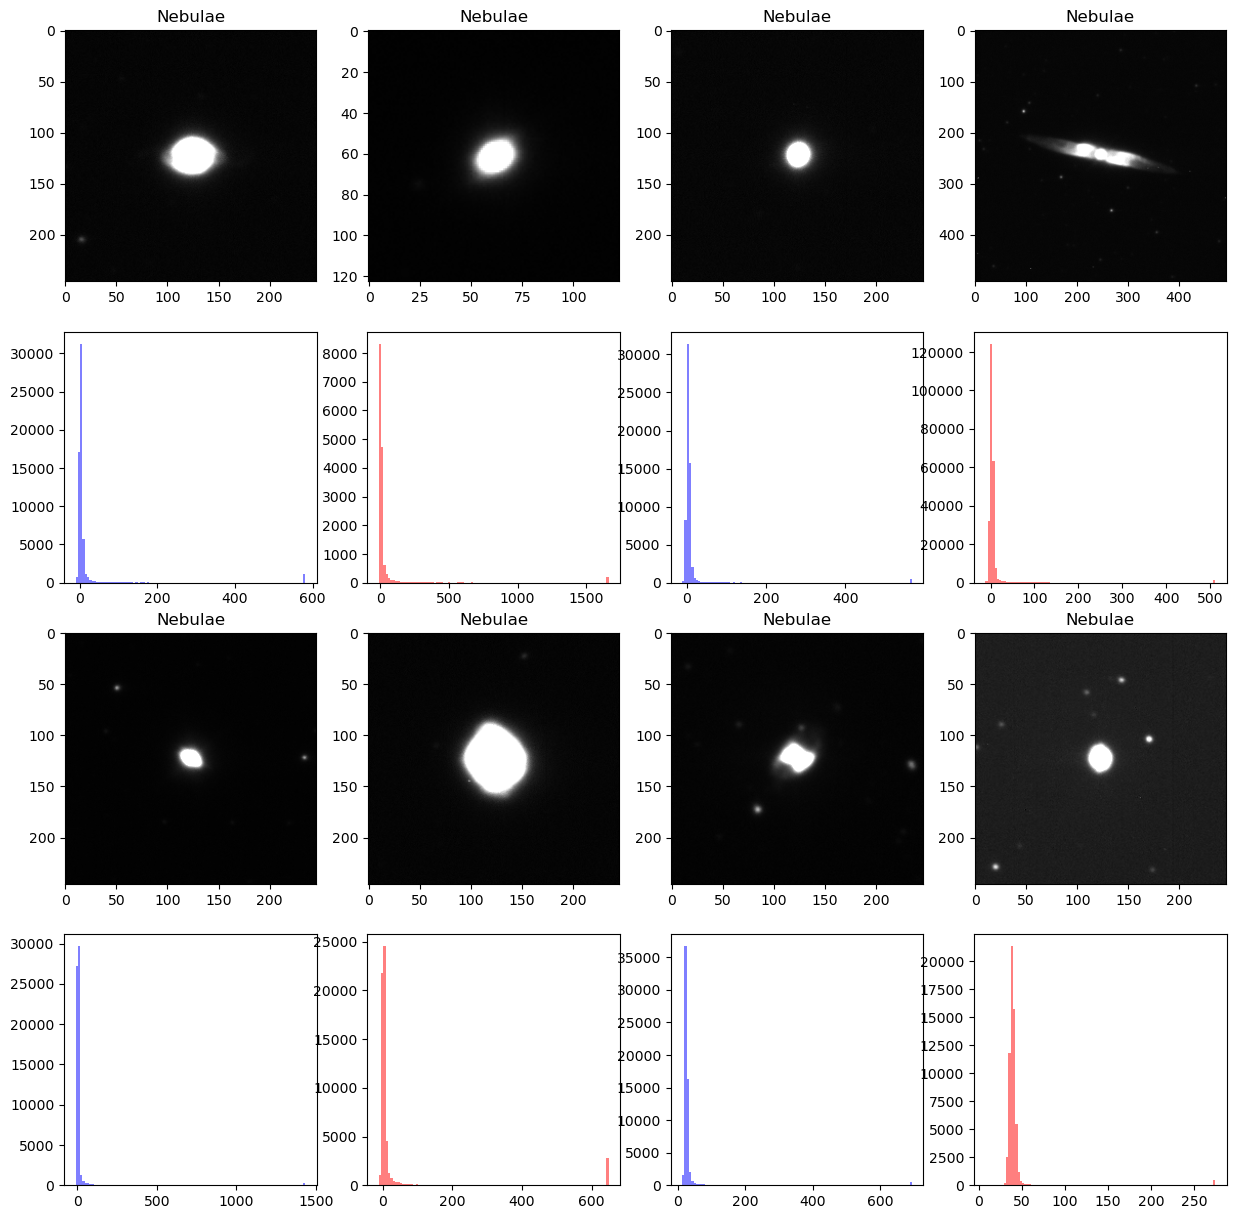

In [54]:
fig, axis = plt.subplots(4, 4, figsize = (15, 15))
init_index = 48
for i in range(2):
    axis[2*i,0].imshow(dataset_train[init_index+i][0][0], cmap = "gray")
    axis[2*i,0].set_title("Nebulae")
    
    axis[2*i,1].imshow(dataset_train[init_index+i+1][0][0], cmap = "gray")
    axis[2*i,1].set_title("Nebulae")
    
    axis[2*i,2].imshow(dataset_train[init_index+i+2][0][0], cmap = "gray")
    axis[2*i,2].set_title("Nebulae")
    
    axis[2*i,3].imshow(dataset_train[init_index+i+3][0][0], cmap = "gray")
    axis[2*i,3].set_title("Nebulae")
    
    _ = axis[2*i+1,0].hist(dataset_train[init_index+i][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
    _ = axis[2*i+1,1].hist(dataset_train[init_index+i+1][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Nebulae")
    _ = axis[2*i+1,2].hist(dataset_train[init_index+i+2][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
    _ = axis[2*i+1,3].hist(dataset_train[init_index+i+3][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Nebulae")
    
    init_index += 3

In [89]:
nebulae_stats_df = pd.DataFrame(nebulae_stats, columns = ["mean", "std", "min", "max"])
background_stats_df = pd.DataFrame(background_stats, columns = ["mean", "std", "min", "max"])

In [90]:
nebulae_stats_df.describe().iloc[1]

mean    0.935350
std     0.038752
min     0.790767
max     0.987483
Name: mean, dtype: float64

In [91]:
background_stats_df.describe().iloc[1]

mean    0.496992
std     0.215662
min     0.057484
max     0.888327
Name: mean, dtype: float64